In [2]:
from counter import counter
cc = counter('count-cooc-top20k-strat30-WoS-econ')

Loading count-cooc-top20k-strat30-WoS-econ from disk...


In [3]:
import numpy as np

In [4]:
from matplotlib import pyplot as plt

In [5]:
len(cc.items('t'))

1500

# the math

$$ \frac{ \text{count-t}(a) }{ \sum \text{count-t}(a) } = 1 $$
$$ \sum_b{ \text{count-t.t}(a,b) } = 5 \sum \text{count-t}(a) $$

$$ P( \text{b shows up after a} ) = 1 - \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] } $$

$$ P( w_{j+N} = b | w_j = a ) = ?? $$

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) \in [0, 5] $$

Now I want to measure how surprising a given connection is compared to the individual propensities.
Something similar to // independence indicates that

$$P(A \& B) = P(A) * P(B|A) = P(A) * P(B)$$

Where the last equality expresses the independence assumption. The extent to which the leftmost and rightmost quantities differ is a good measure for the relevance of a single tie between events.
So, assume $a$ and $b$ are independent events. From above we know that

$$P(a \to b) = \prod_N{ \left[ 1 - P( w_{j+N} = b | w_j = a ) \right] }$$

And by independence this is just

$$ \prod_N{ \left[ 1 - P( w_{j+N} = b ) \right] } $$

$$ P( w_{j+N} = b ) = \text{count-t}(b) * 5 $$

So we almost get what we want... Let's try another combo of formulas...

$$ \frac{ \text{count-t.t}(a,b) }{ \text{count-t}(a) } = \sum_{N=1}^5 P( w_{j+N} = b | w_j = a ) $$
$$ = \sum_{N=1}^5 P( w_{j+N} = b ) = \sum_{N=1}^5 \frac{ \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} } = \frac{ 5 * \text{count-t}(b) }{ \sum_b{\text{count-t}(b)} }  $$

By this math the relevant ratio is

$$ \frac{ \text{count-t.t}(a,b) * \sum_b{\text{count-t}(b)} }{ \text{count-t}(a) * \text{count-t}(b) } = 5 $$

# generate the network

In [6]:
cc.counts.keys()

dict_keys([('fy', 't'), ('fj', 't'), ('fy',), ('t',), ('fj',), ('t1', 't2'), ('fy', 't1', 't2')])

In [7]:
tot = cc.counts[('t',)].sum()
terms = cc.items('t')

In [8]:
rats = []
pairs = []

for t1 in terms:
    for t2 in terms:
        if t1 == t2:
            continue
        
        ca = cc(t=t1)
        cb = cc(t=t2)
        cab = cc(t1=t1, t2=t2)
        
        if cab < 10 or ca < 10 or cb < 10:
            continue

        rat = tot * cab / (ca * cb)
        pairs.append( (cc.ids['t'][t1], cc.ids['t'][t2]) )
        rats.append( rat )

In [9]:
rats = np.array(rats)

In [10]:
np.argwhere( rats > 250 ).shape

(1173, 1)

In [11]:
np.argwhere( rats < 250 ).shape

(11410, 1)

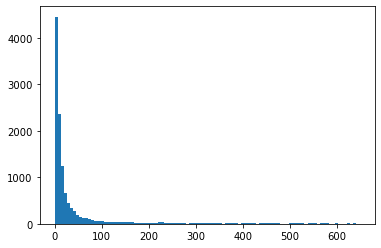

In [12]:
plt.hist( rats[(rats<250+400)&(rats>0)], bins=100 );

In [13]:
np.mean(rats)

101.46262940701719

In [14]:
np.quantile(rats, 0.9)

226.89770129716564

In [15]:
from random import sample

In [16]:
tops = np.argwhere( rats > np.quantile(rats, 0.99) ).flatten()
tops = list(tops)

for i in sample( tops, 100 ):
    ai, bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    ac = cc.counts[('t',)][ai]
    bc = cc.counts[('t',)][bi]
    abc = cc.counts[('t1','t2')][(ai,bi)]
    bac = cc.counts[('t1','t2')][(bi,ai)]
    print( (at, bt, rats[i], ac, bc, abc, bac) )

('sources', 'sources-of', 2416.4527027027025, 148, 93, 11, 3)
('empiricalanalysis', 'empiricalanalysis-of', 2368.4437086092717, 151, 68, 0, 0)
('nd-edition', 'edition', 2249.276729559748, 63, 159, 0, 0)
('the-future', 'future-of', 3076.430107526882, 90, 62, 1, 2)
('incidence', 'incidence-of', 2307.3225806451615, 155, 96, 0, 0)
('the-term', 'term-structure', 2628.345414275647, 77, 129, 1, 0)
('nature', 'nature-and', 1790.6298958249213, 203, 61, 0, 2)
('after', 'after-the', 1912.4866310160428, 187, 72, 4, 0)
('a-casestudy', 'casestudy-of', 2907.60162601626, 82, 66, 0, 0)
('properties', 'properties-of', 1975.8839779005525, 181, 149, 0, 0)
('time-series', 'series', 2802.8391857506363, 75, 131, 0, 0)
('renewable', 'renewable-energy', 2485.1142070863434, 153, 95, 0, 0)
('geography', 'geography-of', 2017.9058159722222, 180, 64, 0, 0)
('gains', 'gains-from', 2116.183431952663, 169, 77, 0, 0)
('origins', 'origins-of', 3373.9150943396226, 106, 71, 0, 0)
('the-rise', 'rise-of', 2906.4939682539684

# dump network

In [17]:
import networkx as nx

In [18]:
rats = np.array(rats)
cutoff = np.quantile(rats[rats>0], 0.93)
cutoff

377.5702622060917

In [19]:
G = nx.DiGraph()

edges = []

for i, r in enumerate(rats):
    if r < cutoff:
        continue
    
    ai,bi = pairs[i]
    at = [x for x,i in cc.ids['t'].items() if i==ai][0]
    bt = [x for x,i in cc.ids['t'].items() if i==bi][0]
    
    edges.append( [at,bt,r] )

G.add_weighted_edges_from(edges)

In [20]:
edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(G,'weight').items()])

In [21]:
deg = np.array(list(x[1] for x in G.degree()))

In [22]:
DEG_CUTOFF = 2
print(
    np.where( deg >= DEG_CUTOFF )[0].shape,
    np.where( deg < DEG_CUTOFF )[0].shape
)

G.remove_nodes_from( list(np.where( deg < DEG_CUTOFF )[0]) )

(481,) (489,)


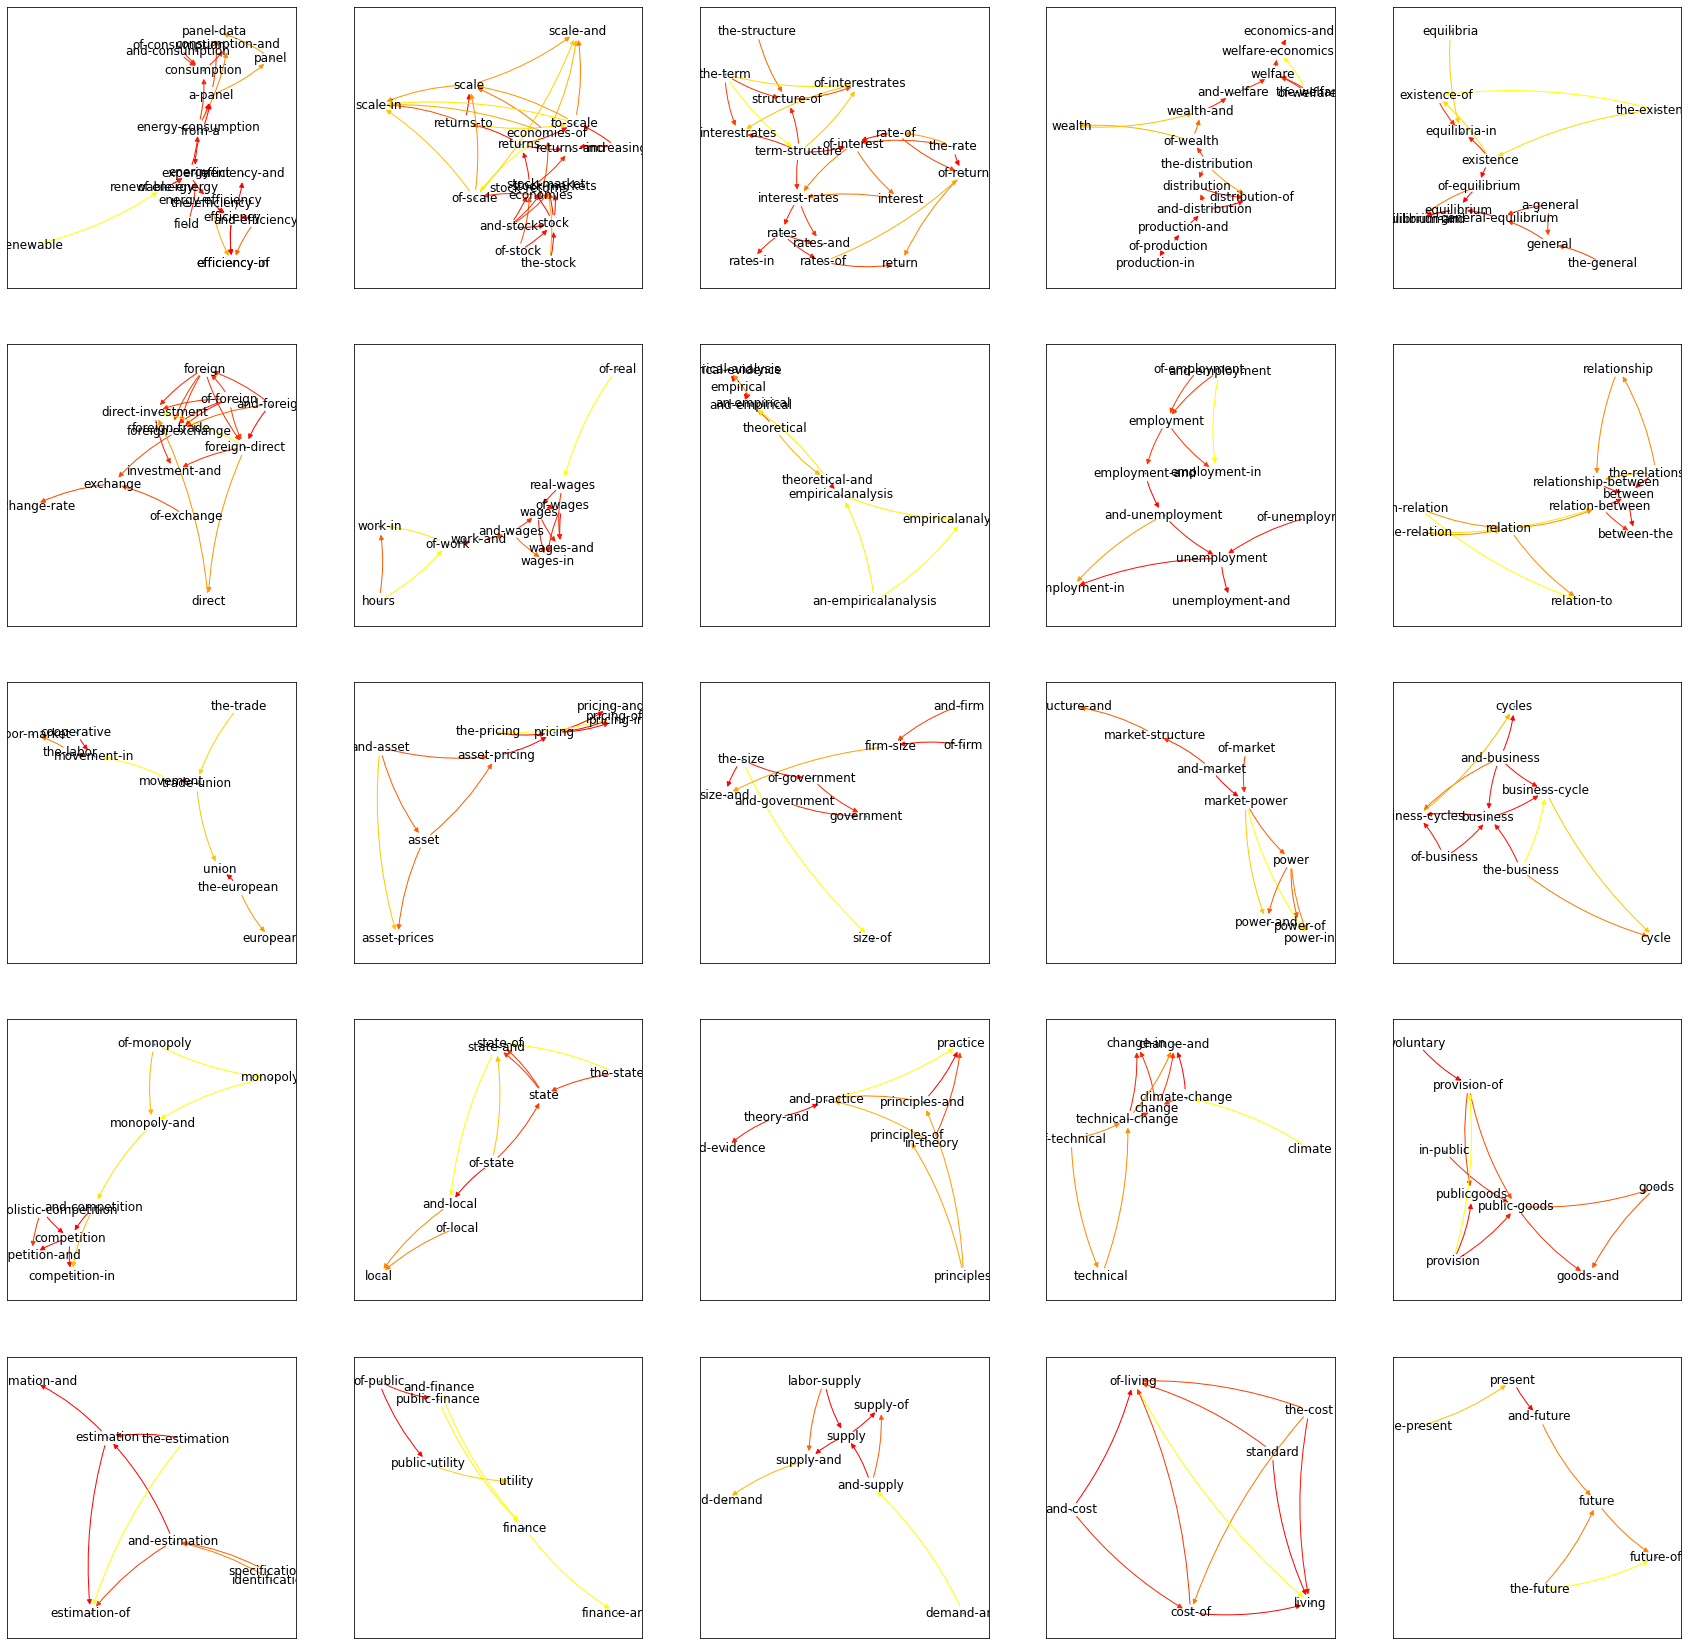

In [24]:
R, C = 5,5

nodes_list = list(nx.connected_components(G.to_undirected()))
nodes_list = sorted(nodes_list, key=lambda x:-len(x))

x_off = 0.1
y_off = 0.1

plt.figure(figsize=(6*R,6*C))

for i,Gcomp_nodes in enumerate(nodes_list[:R*C]):
    plt.subplot(R,C,i+1)
    Gcomp = nx.subgraph(G, Gcomp_nodes)
    pos = nx.kamada_kawai_layout(Gcomp)#, iterations=150, k=0.5)
    pos_offset = {k:([v[0]+x_off, v[1]+y_off]) for k,v in pos.items()} # not currently used


    edges,weights = zip(*[((e1,e2),w) for (e1,e2),w in nx.get_edge_attributes(Gcomp,'weight').items()])

    c = np.log(weights)
    c /= c.max()

    nx.draw_networkx_edges(Gcomp,pos,edgelist=edges,edge_cmap=plt.cm.autumn,edge_color=c,
        connectionstyle="arc3,rad=0.1")
    nx.draw_networkx_nodes(Gcomp,pos,node_size=1)
    nx.draw_networkx_labels(Gcomp,pos)

# noticing extreme structural similarity

I keep trying to plot these networks and notice multiple nodes which lie exactly on top of each other.
They have very strong ties to each other, and the same ties to other blocks.

The following simply orders the nodes by pairwise iterative simularity, and shows the reordered matrix using `imshow`.
It's clear we need to be clustering all the time.

In [43]:
from sklearn.metrics import pairwise_distances

In [69]:
items = sorted(pos.keys())
vals = np.array( [pos[k] for k in items] )

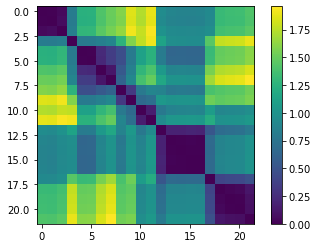

In [71]:
all_ds = pairwise_distances(vals)

new_order = [0]
while len(new_order) < vals.shape[0]:
    ds = all_ds[new_order[-1], :]
    for i in np.argsort(ds):
        if i == new_order[-1]:
            continue
        if i in new_order:
            continue
        new_order.append(i)
        break

ordered_ds = all_ds[new_order,:]
ordered_ds = ordered_ds[:,new_order]
plt.imshow(ordered_ds)
plt.colorbar()

In [72]:
ordered_items = [items[i] for i in new_order]
ordered_items[:5]

['a-panel', 'panel', 'panel-data', 'efficiency-and', 'energy-efficiency']

In [74]:
#iterative_d = [ ordered_ds[i,i+1] for i in range(ordered_ds.shape[0]-1) ]
clusters = []
current_c = [0]
for i in range(0,ordered_ds.shape[0]-1):
    if ordered_ds[i,i+1] < 0.3:
        current_c.append(i+1)
    else:
        clusters.append(current_c)
        current_c = [i+1]

In [75]:
for ci, c in enumerate(clusters):
    print(f"Cluster {ci+1}")
    for i in c:
        print(f"+ {ordered_items[i]}")
    print("")

Cluster 1
+ a-panel
+ panel
+ panel-data

Cluster 2
+ efficiency-and

Cluster 3
+ energy-efficiency
+ efficiency
+ the-efficiency
+ efficiency-of

Cluster 4
+ and-efficiency

Cluster 5
+ efficiency-in

Cluster 6
+ field
+ experiment

Cluster 7
+ from-a
+ of-energy
+ energy
+ renewable
+ renewable-energy

Cluster 8
+ energy-consumption

